In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, r2_score, precision_recall_fscore_support
import common.metrics as met
import common.plots as plo

from common.h5py_loading import load_target_map, load_dataset
from common.h5py_data_loader import H5pyDataLoader
from common.prediction_analysis import df_from_chembl_export, intersect_truth_prediction
from lasagne_nn.run_nn import get_predictions_of_knowns, get_network_from_weights
from lasagne_nn.output_loader import df_from_prediction_path

In [9]:
reload(plo)
figsize = (3.5, 3.5)
sns.set_style("whitegrid")
sns.set_context("paper")

def set_nice_spines(ax=None):
    if not ax:
        ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)

    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)


/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
def get_preds(dset, fold):
    indir="/srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/predictions/scrambled_idx_no_SMA"
    knowns_file = "{}/scrambled_idx_no_SMA_1.0_{}_fold_{}_regression_knowns.npz".format(indir, dset, fold)
    preds_file = "{}/scrambled_idx_no_SMA_1.0_{}_fold_{}_regression_preds.npz".format(indir, dset, fold)

    pred_npz = np.load(preds_file)
    known_npz = np.load(knowns_file)
    
    prediction = pred_npz["arr_0"]
    truth = known_npz["arr_0"]
    
    return prediction, truth


def get_env_var(handle):
    ''' Get an environment variable given the handle for the bash variable'''
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")


In [11]:
def plot_analysis(d_set, fold, save_name=None, mask=False):
    p, t = get_preds(d_set, fold)
    if mask:
        known_mask = ~np.isnan(t)
        t = t[known_mask]
        p = p[known_mask]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale=2)
    plt.clf()
    plt.figure(figsize=figsize)
    ax = plo.plot_rsquared(p, t, img_filename=None)

    set_nice_spines(ax.ax_joint)
    
    plt.suptitle('{} at fold {}'.format(d_set, fold), size=18)
    plt.xlim([0.0, 13.95])
    plt.ylim([0.0, 13.95])
    plt.tight_layout()
    
    if save_name:
        plt.savefig(save_name)
        plt.close()
    else: 
        plt.show()
    
    del p
    del t

In [12]:
save_base = get_env_var("HOME")

img_base ="{}/labgits/lab-notebook-caceres.wiki/images".format(save_base)
expt_base = "{}/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA".format(img_base)
img_fmter = "{}/{}_at_fold_{}_r2.png".format(expt_base, "{}", "{}")

In [6]:
!mkdir -p $expt_base

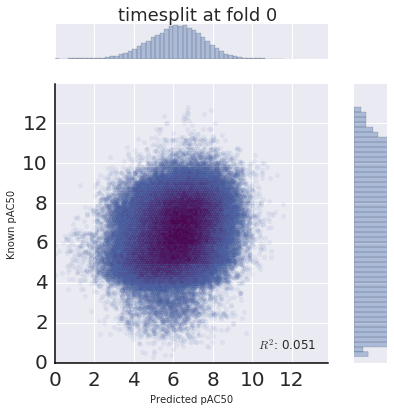

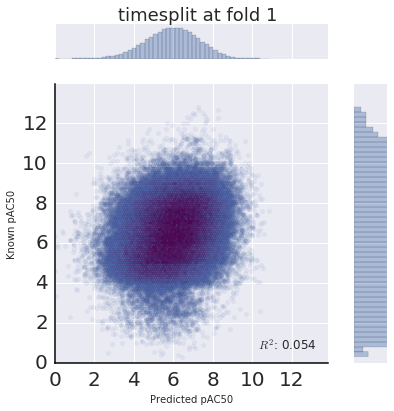

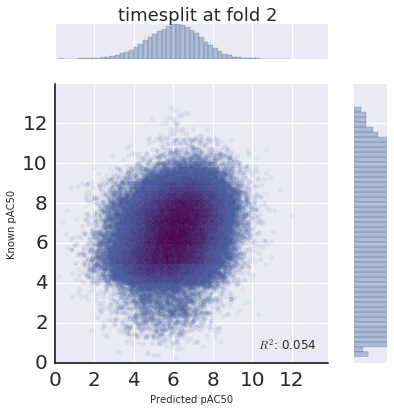

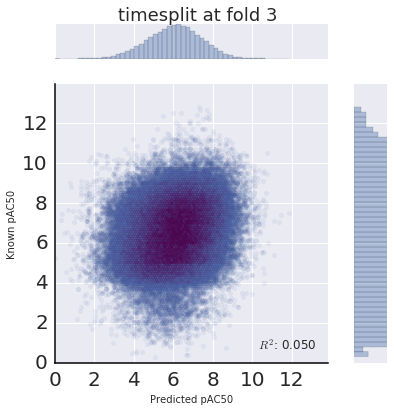

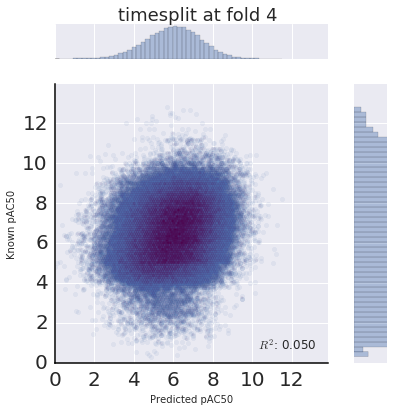

In [13]:
d_set = "timesplit"
folds = ["0", "1", "2", "3", "4"]
for f in folds: 
    plot_analysis(d_set, f, mask=True)

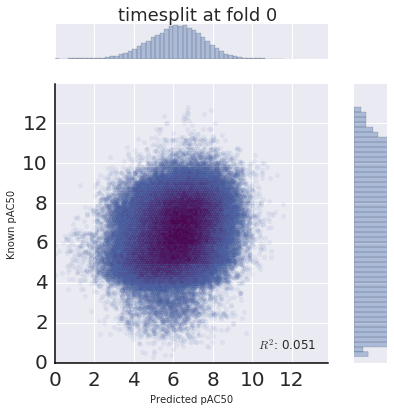

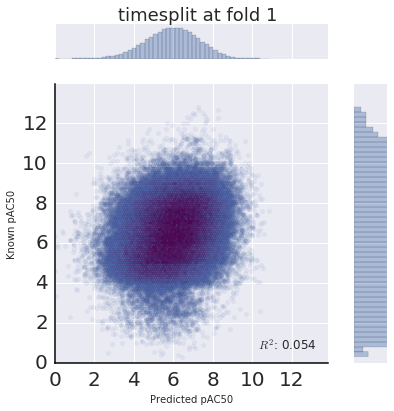

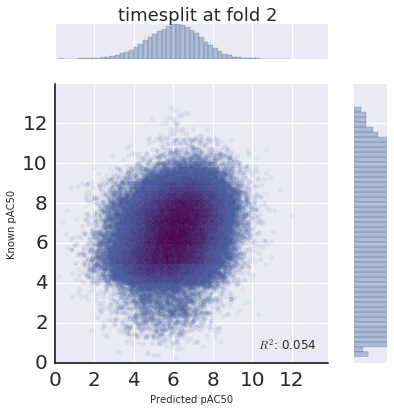

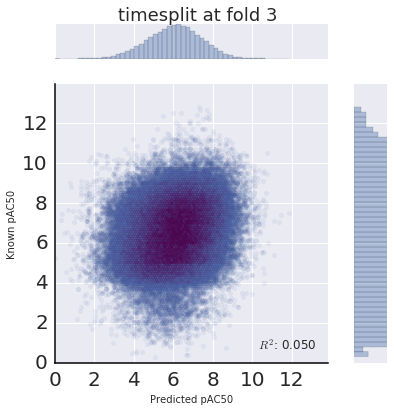

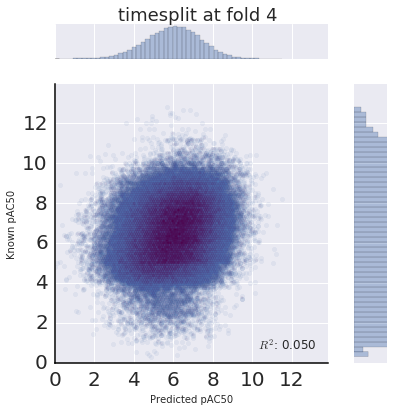

In [14]:
d_set = "timesplit"
folds = ["0", "1", "2", "3", "4"]
for f in folds: 
    plot_analysis(d_set, f, mask=False)

In [7]:
d_set = "timesplit"
folds = ["0", "1", "2", "3", "4"]
for f in folds: 
    plot_analysis(d_set, f, save_name=img_fmter.format(d_set, f))

In [8]:
d_set = "drugmatrix"
folds = ["0", "1", "2", "3", "4"]
for f in folds: 
    plot_analysis(d_set, f, save_name=img_fmter.format(d_set, f))

In [9]:
d_set = "test"
folds = ["0", "1", "2", "3", "4"]
for f in folds: 
    plot_analysis(d_set, f, save_name=img_fmter.format(d_set, f))

In [10]:
d_set = "train"
folds = ["0", "1", "2", "3", "4"]
for f in folds: 
    plot_analysis(d_set, f, save_name=img_fmter.format(d_set, f))

## Format for Lab Notebook

In [13]:
from glob import glob

def format_md_img(link_name, rel_plot_loc):
    img_formatter="[[{}/{}]]".format(link_name, rel_plot_loc)
    return img_formatter

def print_table(list_of_headers):
    fmter =  "| {} {}".format("{}", " {} ")
    for header in list_of_headers:
        fmter = fmter.format("{} {}".format(header, "| {}"), "{}")
    fmter = fmter.format(" ", " ")
    return fmter

In [14]:
github_wiki_link="https://github.com/keiserlab/lab-notebook-caceres/wiki/images"
github_expt_base = "{}/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA".format(github_wiki_link)

img_order = ['train','test', 'timesplit', 'drugmatrix']
ratio = 1.0
headers = ["PNR_{}".format(ratio)]
headers.extend(img_order)
print(print_table(headers))
print(print_table([":---"]*len(headers)))

png_files = glob(img_fmter.format("*", "*"))
for f in np.arange(0, 5, 1):
    name_fmter = "fold_{}".format(str(f))
    fold_pngs = [i for i in png_files if name_fmter in i]
    fold_pngs = sorted(fold_pngs, key=lambda x: img_order.index(x.split("/")[-1].split(".")[0].split("_")[0]))
    md_print_fmt = [name_fmter] + [format_md_img(github_expt_base, i.split("/")[-1]) for i in fold_pngs]
    print(print_table(md_print_fmt))
print("\n\n")

| PNR_1.0 | train | test | timesplit | drugmatrix |      
| :--- | :--- | :--- | :--- | :--- |      
| fold_0 | [[https://github.com/keiserlab/lab-notebook-caceres/wiki/images/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA/train_at_fold_0_r2.png]] | [[https://github.com/keiserlab/lab-notebook-caceres/wiki/images/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA/test_at_fold_0_r2.png]] | [[https://github.com/keiserlab/lab-notebook-caceres/wiki/images/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA/timesplit_at_fold_0_r2.png]] | [[https://github.com/keiserlab/lab-notebook-caceres/wiki/images/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA/drugmatrix_at_fold_0_r2.png]] |      
| fold_1 | [[https://github.com/keiserlab/lab-notebook-caceres/wiki/images/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA/train_at_fold_1_r2.png]] | [[https://github.com/keiserlab/lab-notebook-cace